# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using Estimator. It is a companion to <a href="mnist_estimator.ipynb"> mnist_estimator.ipynb </a> which contains the code for the harness.  The Python package itself is in <a href="mnistmodel">mnistmodel</a>

Note the MODEL_TYPE; change it to try out different models

In [1]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE='cnn'  # 'linear', 'dnn', 'dnn_dropout', or 'cnn'

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['MODEL_TYPE'] = MODEL_TYPE
os.environ['TFVERSION'] = '1.5'  # Tensorflow version

In [2]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Model functions

Here are the models

### Linear
A simple low-level matrix multiplication

In [3]:
#linear
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  W = tf.get_variable("W", [HEIGHT*WIDTH,NCLASSES], 
                      initializer = tf.truncated_normal_initializer(stddev=0.1,seed = 1))
  b = tf.get_variable("b",NCLASSES, initializer = tf.zeros_initializer)
  ylogits = tf.matmul(X,W)+b
  return ylogits, NCLASSES

### Deep Neural Network

A 3-hidden layer network that uses tf.layers to reduce the boilerplate

In [4]:
# dnn
def dnn_model(img, mode):
  X = tf.reshape(img, [-1, HEIGHT*WIDTH]) # flattened
  h1 = tf.layers.dense(X, 300, activation=tf.nn.relu)
  h2 = tf.layers.dense(h1,100, activation=tf.nn.relu)
  h3 = tf.layers.dense(h2, 30, activation=tf.nn.relu)
  ylogits = tf.layers.dense(h3, NCLASSES, activation=None)
  return ylogits, NCLASSES

### DNN with dropout

A 3-hidden layer network with a dropout layer between layer 3 and the output

In [5]:
 def dnn_dropout_model(img, mode):
  X = tf.reshape(img, [-1, HEIGHT*WIDTH]) # flattened
  h1 = tf.layers.dense(X, 300, activation=tf.nn.relu)
  h2 = tf.layers.dense(h1,100, activation=tf.nn.relu)
  h3 = tf.layers.dense(h2, 30, activation=tf.nn.relu)
  h3d = tf.layers.dropout(h3, rate=0.1, training=(mode == tf.estimator.ModeKeys.TRAIN))
  ylogits = tf.layers.dense(h3d, NCLASSES, activation=None)
  return ylogits, NCLASSES

### CNN
2 convolutional layers, both wrapped into maxpool layers, followed by a dense layer and then a dropout

In [6]:
def cnn_model(img, mode):
  X = tf.reshape(img, [-1, HEIGHT, WIDTH, 1]) # as a 2D image with one grayscale channel
  c1 = tf.layers.max_pooling2d(
         tf.layers.conv2d(X, filters=10,
                          kernel_size=5, strides=1, # ?x28x28x10
                          padding='same', activation=tf.nn.relu), 
         pool_size=2, strides=2
       ) # ?x14x14x10
  c2 = tf.layers.max_pooling2d(
         tf.layers.conv2d(c1, filters=20,
                          kernel_size=5, strides=1, 
                          padding='same', activation=tf.nn.relu),
         pool_size=2, strides=2
       ) # ?x7x7x20
  outlen = (HEIGHT//4)*(WIDTH//4)*20 # integer division; 980
  c2flat = tf.reshape(c2, [-1, outlen]) # flattened
  h3 = tf.layers.dense(c2flat, 300, activation=tf.nn.relu)
  h3d = tf.layers.dropout(h3, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
  ylogits = tf.layers.dense(h3d, NCLASSES, activation=None)
  return ylogits, NCLASSES

### CNN with batchnorm

With batch normalization, and using hyperparameterization

In [7]:
def cnn_model(img, mode, hparams):
  ksize1 = hparams.get('ksize1', 5)
  ksize2 = hparams.get('ksize2', 5)
  nfil1 = hparams.get('nfil1', 10)
  nfil2 = hparams.get('nfil2', 20)
  dprob = hparams.get('dprob', 0.25)

  X = tf.reshape(img, [-1, HEIGHT, WIDTH, 1]) # as a 2D image with one grayscale channel
  c1 = tf.layers.max_pooling2d(
         tf.layers.conv2d(X, filters=nfil1,
                          kernel_size=ksize1, strides=1, # ?x28x28x10
                          padding='same', activation=tf.nn.relu),
         pool_size=2, strides=2
       ) # ?x14x14x10
  c2 = tf.layers.max_pooling2d(
         tf.layers.conv2d(c1, filters=nfil2,
                          kernel_size=ksize2, strides=1, 
                          padding='same', activation=tf.nn.relu),
         pool_size=2, strides=2
       ) # ?x7x7x20

  outlen = (HEIGHT//4)*(WIDTH//4)*nfil2 # integer division; 980
  c2flat = tf.reshape(c2, [-1, outlen]) # flattened

  if hparams['batch_norm']:
    h3 = tf.layers.dense(c2flat, 300, activation=None)
    h3 = tf.layers.batch_normalization(h3, training=(mode == tf.estimator.ModeKeys.TRAIN))
    h3 = tf.nn.relu(h3)
  else:  
    h3 = tf.layers.dense(c2flat, 300, activation=tf.nn.relu)

  h3d = tf.layers.dropout(h3, rate=dprob, training=(mode == tf.estimator.ModeKeys.TRAIN))

  ylogits = tf.layers.dense(h3d, NCLASSES, activation=None)

  if hparams['batch_norm']:
     ylogits = tf.layers.batch_normalization(ylogits, training=(mode == tf.estimator.ModeKeys.TRAIN))

  return ylogits, NCLASSES

## Run as a Python module

Let's run it as Python module.  Note the --model parameter

In [ ]:
%bash
rm -rf mnistmodel.tar.gz mnist_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/mnistmodel
python -m trainer.task \
   --output_dir=${PWD}/mnist_trained \
   --train_steps=10 --learning_rate=0.01 --model=$MODEL_TYPE --job-dir=./tmp
#python -m trainer.task --help

Now, let's do it on ML Engine. Note the --model parameter

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=$TFVERSION \
   -- \
   --output_dir=$OUTDIR \
   --train_steps=10000 --learning_rate=0.01 --train_batch_size=512 \
   --model=$MODEL_TYPE --batch_norm
    
#--nfil1=16 --nfil2=18

Here are my results:

Model | Accuracy | Time taken | Model description | Run time parameters
--- | :---: | ---
linear | 91.53 | 3 min | | 100 steps, LR=0.01, Batch=512
linear | 92.73 | 8 min | | 1000 steps, LR=0.01, Batch=512
linear | 92.29 | 18 min | | 10000 steps, LR=0.01, Batch=512
dnn | 98.14 | 15 min | 300-100-30 nodes fully connected | 10000 steps, LR=0.01, Batch=512
dnn | 97.99 | 48 min | 300-100-30 nodes fully connected | 100000 steps, LR=0.01, Batch=512
dnn_dropout | 97.84 | 29 min | 300-100-30-DL(0.1)- nodes | 20000 steps, LR=0.01, Batch=512
cnn | 98.97 | 35 min | maxpool(10 5x5 cnn, 2)-maxpool(20 5x5 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 98.93 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 99.17 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits only) | 20000 steps, LR=0.01, Batch=512
cnn | 99.27 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits, deep) | 10000 steps, LR=0.01, Batch=512
cnn | 99.48 | 12 hr | as-above but nfil1=20, nfil2=27, dprob=0.1, lr=0.001, batchsize=233 | (hyperparameter optimization)

## DO NOT RUN anything beyond this point

This shows you what I did, but trying to repeat this will take several hours.

<br/>

## Hyperparameter tuning

The key thing is here the --config parameter

In [25]:
!cat hyperparam.yaml

trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_m_gpu
  hyperparameters:
    goal: MAXIMIZE
    maxTrials: 30
    maxParallelTrials: 2
    hyperparameterMetricTag: accuracy
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 32
      maxValue: 512
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: learning_rate
      type: DOUBLE
      minValue: 0.001
      maxValue: 0.1
      scaleType: UNIT_LOG_SCALE
    - parameterName: nfil1
      type: INTEGER
      minValue: 5
      maxValue: 20
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: nfil2
      type: INTEGER
      minValue: 10
      maxValue: 30
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: dprob
      type: DOUBLE
      minValue: 0.1
      maxValue: 0.6
      scaleType: UNIT_LINEAR_SCALE

This takes <b>13 hours and 250 ML Units</b>, so don't try this at home :)

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}_hparam
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --runtime-version=$TFVERSION \
   --config hyperparam.yaml \
   -- \
   --output_dir=$OUTDIR \
   --model=$MODEL_TYPE --batch_norm

## Monitoring training with TensorBoard

Use this cell to launch tensorboard

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/mnist/trained_{}'.format(BUCKET, MODEL_TYPE))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print 'Stopped TensorBoard with pid {}'.format(pid)

Here's what it looks like with a linear model for 10,000 steps:
<img src="images/eval_linear_10000.png" width="60%"/>

## Deploying and predicting with model

Deploy the model:

In [ ]:
%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/Servo | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

To predict with the model, let's take one of the example images.

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


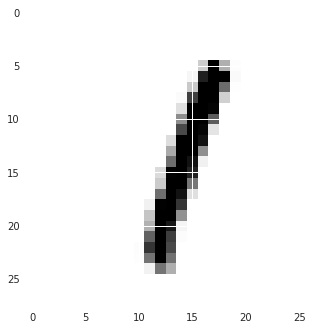

In [20]:
import json, codecs
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

HEIGHT=28
WIDTH=28

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
IMGNO=5
jsondata = {'image': [mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()]}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [23]:
%bash
gcloud ml-engine predict --model=mnist --version=${MODEL_TYPE} --json-instances=./test.json

CLASSES  PROBABILITIES
1        [2.568064516594859e-08, 0.9999994039535522, 4.309508912919702e-12, 7.756620866439246e-12, 3.8694295767527365e-07, 3.6948806236836162e-09, 2.1442110587077678e-10, 1.8663308676281076e-09, 2.1750084044924733e-07, 1.3390479046762604e-12]


<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>